# Sensitivity Analysis

## 1. Define the problem and policies

In [1]:
# Imports

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, MultiprocessingEvaluator, perform_experiments, ema_logging, Policy, Scenario)
ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties, sample_levers
from ema_workbench.util import ema_logging, save_results, load_results
from specify import specify_levers


from SALib.analyze import sobol
from plotting_for_sobol import plot_sobol_indices, plot_scores


C:\Users\frac1\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')


In [2]:
# Specification of the problem

from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(1)

#Specification of the policies

n_policies = 4
policy0 = Policy('policy_0', **{'0_RfR 0': 0, '0_RfR 1' : 0, '0_RfR 2' : 0,
                    '1_RfR 0': 0, '1_RfR 1' : 0, '1_RfR 2' : 0,
                    '2_RfR 0': 0, '2_RfR 1' : 0, '2_RfR 2' : 0,
                    '3_RfR 0': 0, '3_RfR 1' : 0, '3_RfR 2' : 0,
                    '4_RfR 0': 0, '4_RfR 1' : 0, '4_RfR 2' : 0,
                    'A.1_DikeIncrease 0' : 0, 'A.1_DikeIncrease 1' : 0, 'A.1_DikeIncrease 2' : 0,
                    'A.2_DikeIncrease 0' : 0, 'A.2_DikeIncrease 1' : 0, 'A.2_DikeIncrease 2' : 0,
                    'A.3_DikeIncrease 0' : 0, 'A.3_DikeIncrease 1' : 0, 'A.3_DikeIncrease 2' : 0,
                    'A.4_DikeIncrease 0' : 0, 'A.4_DikeIncrease 1' : 0, 'A.4_DikeIncrease 2' : 0,
                    'A.5_DikeIncrease 0' : 0, 'A.5_DikeIncrease 1' : 0, 'A.5_DikeIncrease 2' : 0,
                    'EWS_DaysToThreat':  0   }) # DO NOTHING
policy1 = Policy('policy_1', **{'0_RfR 0': 0, '0_RfR 1' : 0, '0_RfR 2' : 0,
                    '1_RfR 0': 0, '1_RfR 1' : 0, '1_RfR 2' : 0,
                    '2_RfR 0': 0, '2_RfR 1' : 0, '2_RfR 2' : 0,
                    '3_RfR 0': 0, '3_RfR 1' : 0, '3_RfR 2' : 0,
                    '4_RfR 0': 0, '4_RfR 1' : 0, '4_RfR 2' : 0,
                    'A.1_DikeIncrease 0' : 10, 'A.1_DikeIncrease 1' : 0, 'A.1_DikeIncrease 2' : 0,
                    'A.2_DikeIncrease 0' : 0, 'A.2_DikeIncrease 1' : 0, 'A.2_DikeIncrease 2' : 0,
                    'A.3_DikeIncrease 0' : 10, 'A.3_DikeIncrease 1' : 0, 'A.3_DikeIncrease 2' : 0,
                    'A.4_DikeIncrease 0' : 0, 'A.4_DikeIncrease 1' : 0, 'A.4_DikeIncrease 2' : 0,
                    'A.5_DikeIncrease 0' : 0, 'A.5_DikeIncrease 1' : 0, 'A.5_DikeIncrease 2' : 0,
                    'EWS_DaysToThreat':  0   }) # DO DIKES at A1, A3
policy2 = Policy('policy_2', **{'0_RfR 0': 0, '0_RfR 1' : 0, '0_RfR 2' : 0,
                    '1_RfR 0': 0, '1_RfR 1' : 0, '1_RfR 2' : 0,
                    '2_RfR 0': 0, '2_RfR 1' : 0, '2_RfR 2' : 0,
                    '3_RfR 0': 0, '3_RfR 1' : 0, '3_RfR 2' : 0,
                    '4_RfR 0': 0, '4_RfR 1' : 0, '4_RfR 2' : 0,
                    'A.1_DikeIncrease 0' : 10, 'A.1_DikeIncrease 1' : 0, 'A.1_DikeIncrease 2' : 0,
                    'A.2_DikeIncrease 0' : 10, 'A.2_DikeIncrease 1' : 0, 'A.2_DikeIncrease 2' : 0,
                    'A.3_DikeIncrease 0' : 10, 'A.3_DikeIncrease 1' : 0, 'A.3_DikeIncrease 2' : 0,
                    'A.4_DikeIncrease 0' : 0, 'A.4_DikeIncrease 1' : 0, 'A.4_DikeIncrease 2' : 0,
                    'A.5_DikeIncrease 0' : 10, 'A.5_DikeIncrease 1' : 0, 'A.5_DikeIncrease 2' : 0,
                    'EWS_DaysToThreat':  0   }) # DO DIKES at A1, A2, A3, A5
policy3 = Policy('policy_3', **{'0_RfR 0': 0, '0_RfR 1' : 0, '0_RfR 2' : 0,
                    '1_RfR 0': 1, '1_RfR 1' : 0, '1_RfR 2' : 0,
                    '2_RfR 0': 1, '2_RfR 1' : 0, '2_RfR 2' : 0,
                    '3_RfR 0': 1, '3_RfR 1' : 0, '3_RfR 2' : 0,
                    '4_RfR 0': 1, '4_RfR 1' : 0, '4_RfR 2' : 0,
                    'A.1_DikeIncrease 0' : 10, 'A.1_DikeIncrease 1' : 0, 'A.1_DikeIncrease 2' : 0,
                    'A.2_DikeIncrease 0' : 10, 'A.2_DikeIncrease 1' : 0, 'A.2_DikeIncrease 2' : 0,
                    'A.3_DikeIncrease 0' : 10, 'A.3_DikeIncrease 1' : 0, 'A.3_DikeIncrease 2' : 0,
                    'A.4_DikeIncrease 0' : 10, 'A.4_DikeIncrease 1' : 0, 'A.4_DikeIncrease 2' : 0,
                    'A.5_DikeIncrease 0' : 10, 'A.5_DikeIncrease 1' : 0, 'A.5_DikeIncrease 2' : 0,
                    'EWS_DaysToThreat':  4   }) # DO EVERYTHING

## 2. Sobol's scores

We will run a sensitivity analysis over a total of N(2K+2) experiments, where K is the number of levers availble in the dike model, and N is the baseline number of experiments

In [3]:
# We set the baseline number of experiments (N) here:
N = 100

# Check the number of levers (K) that the model has:
K = len(dike_model.levers)

# The overall number of experiments that will be run is:
n_exp = N*(2*K+2)

print("The overall number of experiments that will be run for the sensitivity analysis using SOBOL is: ", n_exp)

The overall number of experiments that will be run for the sensitivity analysis using SOBOL is:  6400


We now determine the reference scenario for which the sensitivity analysis over the levers will be performed:

In [4]:
# Load policy results of a NoAction policy under 500 scenarios (notebook 1-Reference Case Scenario)
[experiments, outcomes] = load_results("../results/500Scenarios_NoAction_PF1.tar.gz")
outcomes_df = pd.DataFrame(data=outcomes)

#Get index of worst-case scenario
index_wc = outcomes_df.sort_values("Expected Number of Deaths").tail(1).index
experiment_wc = experiments.iloc[index_wc]

#Set the reference scenario as the worst-case scenario
reference_scenario = [Scenario(f"{index}", **row) for index, row in experiment_wc.iloc[0:,0:19].iterrows()]
reference_scenario

[MainProcess/INFO] results loaded succesfully from C:\Users\frac1\Documents\GitHub\Model Based DM - Assignment collaboration\model-based-decision-making\results\500Scenarios_NoAction_PF1.tar.gz


[Scenario({'A.0_ID flood wave shape': 86.0, 'A.1_Bmax': 145.81337140487716, 'A.1_Brate': 1.0, 'A.1_pfail': 0.31593423763642897, 'A.2_Bmax': 248.3581847407406, 'A.2_Brate': 1.5, 'A.2_pfail': 0.05275452120745554, 'A.3_Bmax': 123.7744958092888, 'A.3_Brate': 1.5, 'A.3_pfail': 0.05788937414744059, 'A.4_Bmax': 81.68267234093, 'A.4_Brate': 1.0, 'A.4_pfail': 0.41553292304823536, 'A.5_Bmax': 262.41315850770684, 'A.5_Brate': 1.5, 'A.5_pfail': 0.9413029242249218, 'discount rate 0': 2.5, 'discount rate 1': 1.5, 'discount rate 2': 3.5})]

In [5]:
# Execute Sensistivity Analysis over uncertainties
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
     experiments, outcomes = evaluator.perform_experiments(scenarios = reference_scenario,
                                                           policies = N, 
                                                           levers_sampling = SOBOL)
end = time.time()
print('Sobol time is ' + str(round((end - start)/60)) + ' minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 6400 policies * 1 model(s) = 6400 experiments
[MainProcess/INFO] 640 cases completed
[MainProcess/INFO] 1280 cases completed
[MainProcess/INFO] 1920 cases completed
[MainProcess/INFO] 2560 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3840 cases completed
[MainProcess/INFO] 4480 cases completed
[MainProcess/INFO] 5120 cases completed
[MainProcess/INFO] 5760 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Sobol time is 75 minutes


In [6]:
# Save results
results = (experiments, outcomes)
save_results(results,  "../results/Sensitivity_"+str(n_exp)+"ex_RefScenario.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\frac1\Documents\GitHub\Model Based DM - Assignment collaboration\model-based-decision-making\results\Sensitivity_6400ex_RefScenario.tar.gz


In [7]:
# Load results
experiments, outcomes = load_results("../results/Sensitivity_"+str(n_exp)+"ex_RefScenario.tar.gz")

[MainProcess/INFO] results loaded succesfully from C:\Users\frac1\Documents\GitHub\Model Based DM - Assignment collaboration\model-based-decision-making\results\Sensitivity_6400ex_RefScenario.tar.gz


We will now calculate SOBOL's scores:

In [11]:
outcomes.keys()

dict_keys(['Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths'])

In [8]:
# Convert the problem into an SA-equivalent problem:
problem = get_SALib_problem(dike_model.levers)

# Calculate the scores:
Si = sobol.analyze(problem, outcomes['Expected Annual Damage'],
                   calc_second_order=True, print_to_console=False)

We will now plot such scores

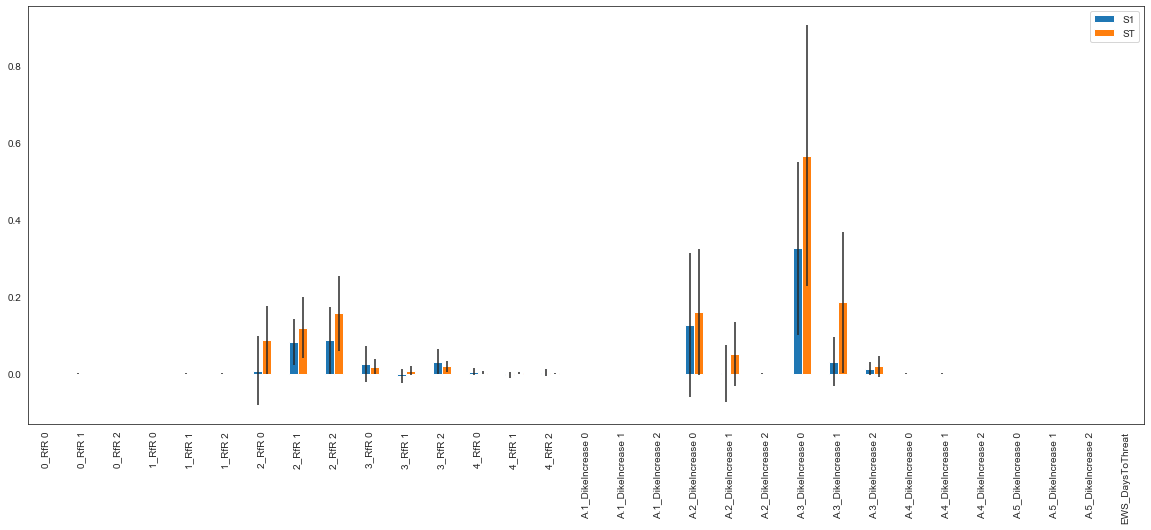

In [9]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(20,10)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [ ]:
import itertools
from math import pi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


#def plot_sobol_indices(sobol_indices, problem, criterion='ST', threshold=0.01):
#    '''plot sobol indices on a radial plot
#    Parameters
#    ----------
#    sobol_indices : dict
#                    the return from SAlib
#    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
#    threshold : float
#                only visualize variables with criterion larger than cutoff
#    '''
#    max_linewidth_s2 = 15
#    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
sobol_stats = {key:Si[key] for key in ['ST', 'S1']}
sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])
#
smax = sobol_stats.max().max()
smin = sobol_stats.min().min()
criterion='ST'
threshold=0.01
max_linewidth_s2 = 15
max_s_radius = 0.3

    # dataframe with s2
s2 = pd.DataFrame(Si['S2'], index=problem['names'],
                      columns=problem['names'])
s2max = s2.max().max()
s2min = s2.min().min()

names = problem['names']
n = len(names)
ticklocs = np.linspace(0, 2*pi, n+1)
locs = ticklocs[0:-1]

filtered_names, filtered_locs = filter(Si, names, locs, criterion, threshold)
 # setup figure
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.grid(False)
ax.spines['polar'].set_visible(False)
ax.set_xticks(ticklocs)
ax.set_xticklabels(names)
ax.set_yticklabels([])
ax.set_ylim(ymax=1.4)
#    legend(ax)

    # plot ST
plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

return fig

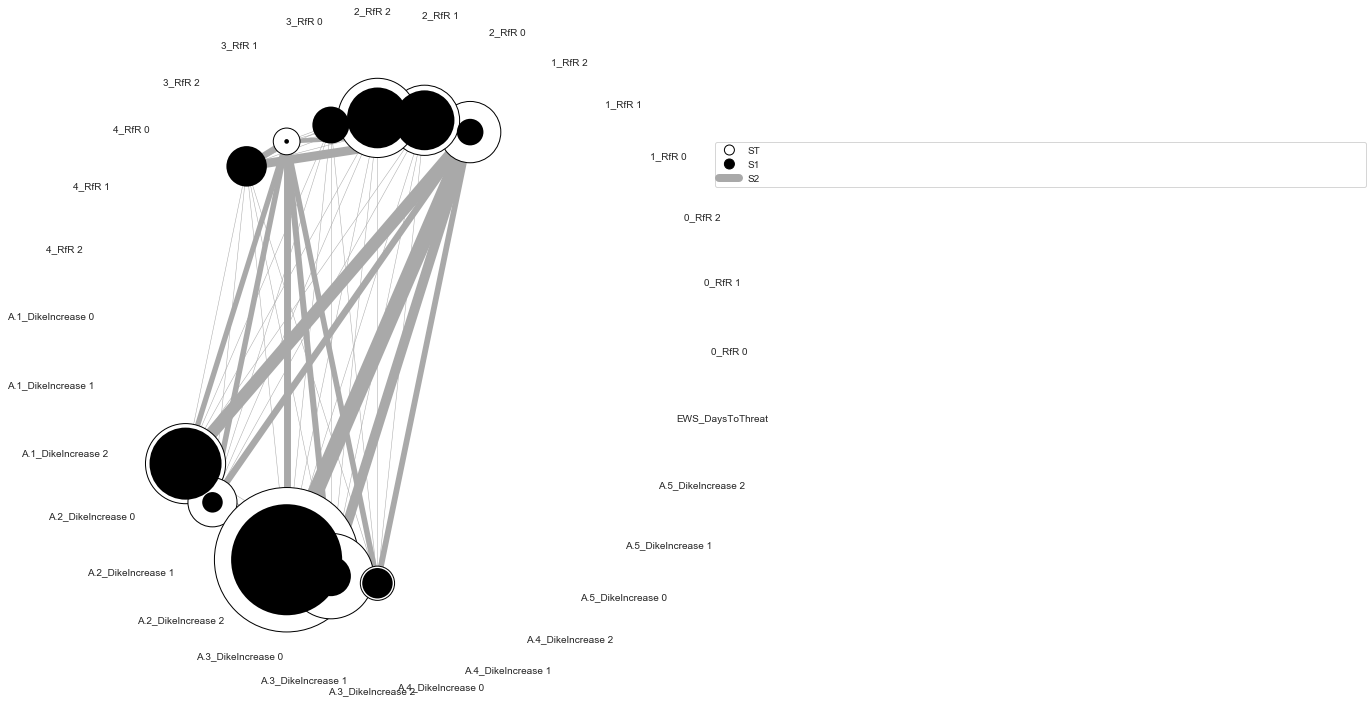

In [10]:
figi = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
figi.set_size_inches(12,12)
figi.axes.append(fig)

plt.show()

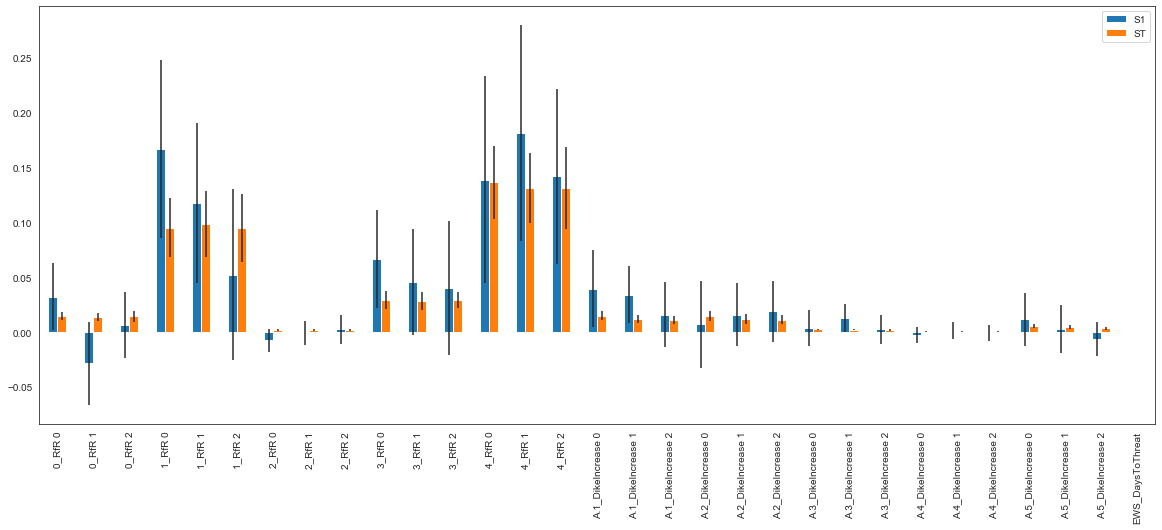

In [12]:
Si = sobol.analyze(problem, outcomes['Total Investment Costs'],
                   calc_second_order=True, print_to_console=False)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(20,10)
fig.subplots_adjust(bottom=0.3)
plt.show()

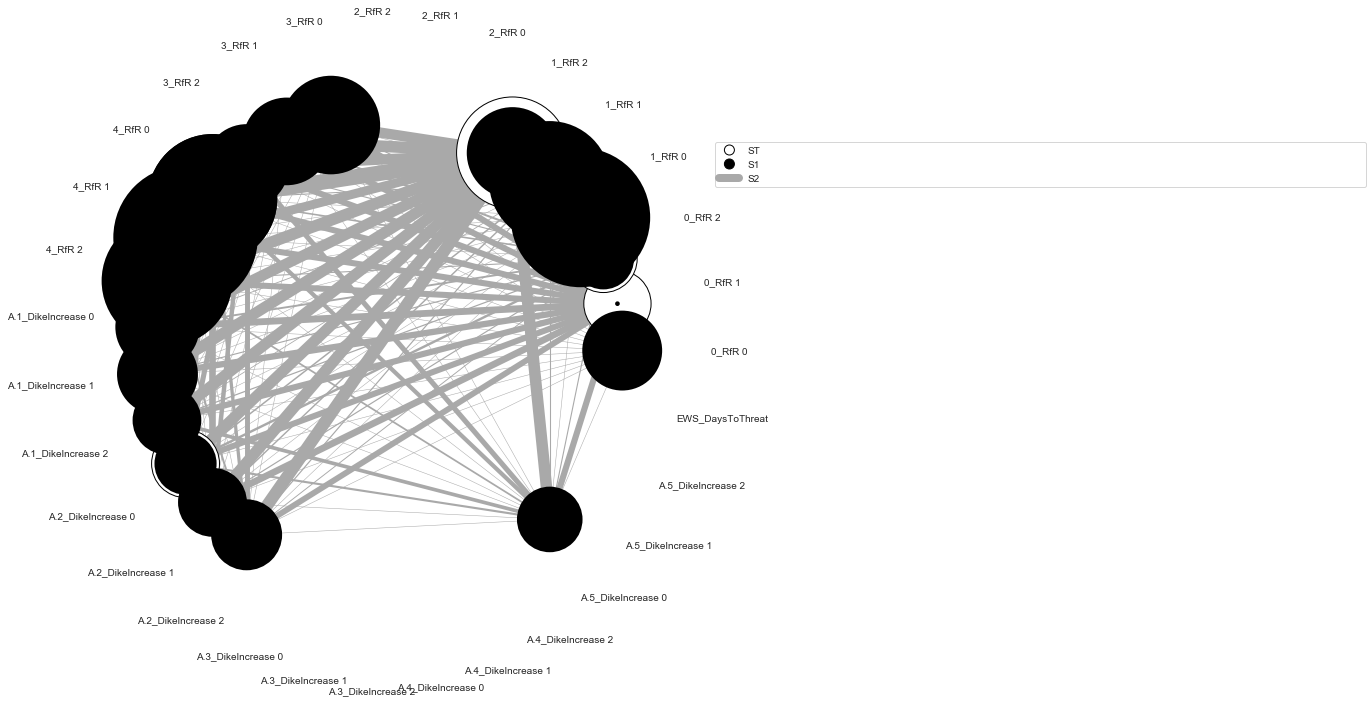

In [13]:
figi = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
figi.set_size_inches(12,12)
figi.axes.append(fig)

plt.show()

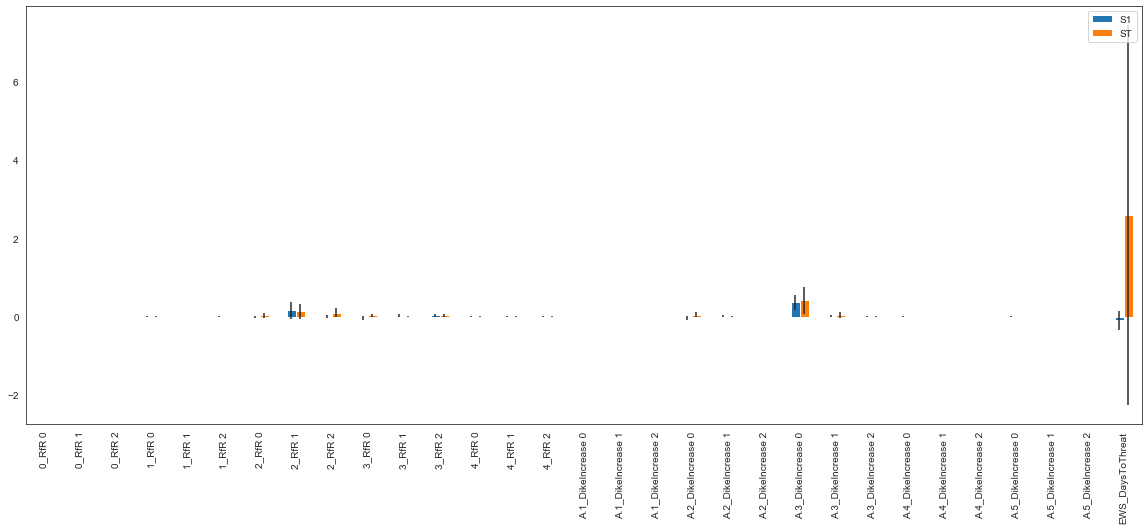

In [14]:
Si = sobol.analyze(problem, outcomes['Expected Number of Deaths'],
                   calc_second_order=True, print_to_console=False)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(20,10)
fig.subplots_adjust(bottom=0.3)
plt.show()

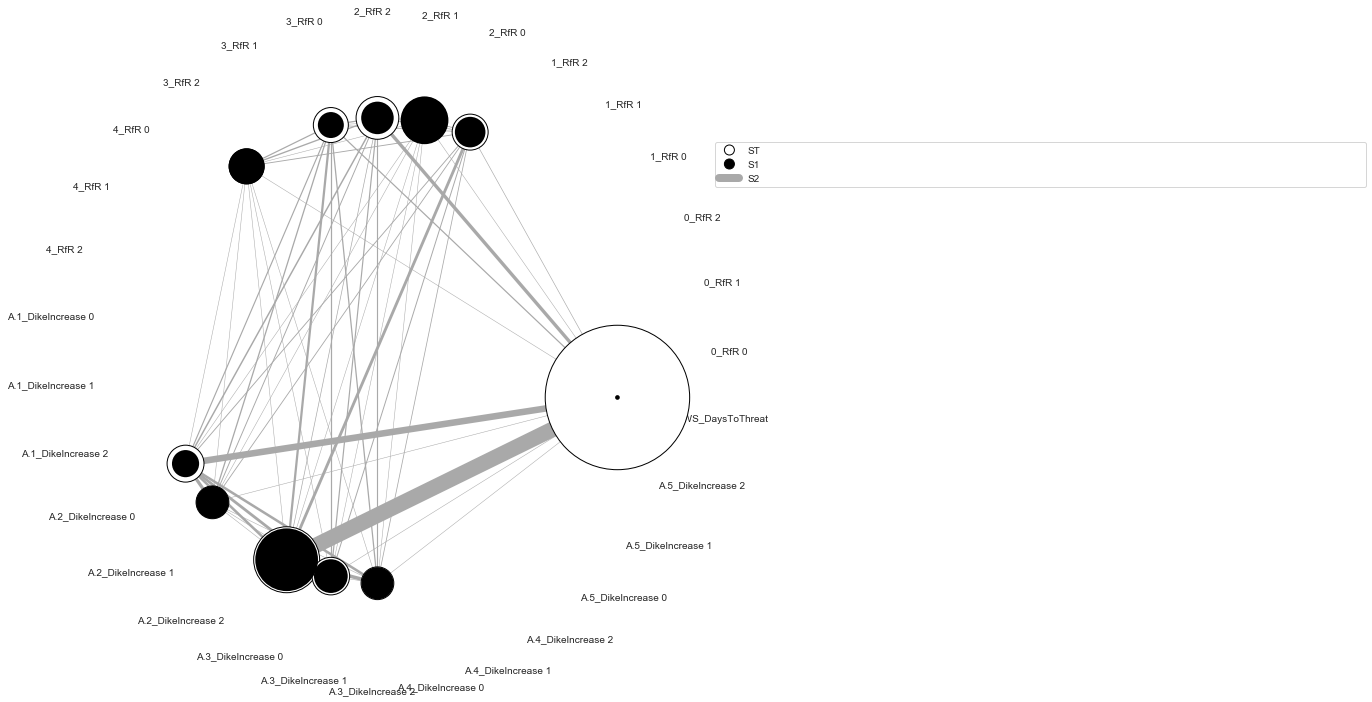

In [15]:
figi = plot_sobol_indices(Si, problem, criterion='ST', threshold=0.005)
figi.set_size_inches(12,12)
figi.axes.append(fig)

plt.show()

## OLS Regression

In [47]:


start = time.time()
results_lhs = perform_experiments(dike_model, scenarios=reference_scenario,
                                  policies=100,
                                  levers_sampling=LHS)
end = time.time()
print('OLS Regression time is ' + str(round((end - start)/60)) + ' minutes')

exp_lhs, out_lhs = results_lhs

[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


OLS Regression time is 7 minutes


In [48]:
out_lhs['Expected Annual Damage'].shape

(100,)

In [49]:

damage_lhs = out_lhs['Expected Annual Damage']
damage_mean_lhs = np.mean(out_lhs['Expected Annual Damage'])
damage_std_lhs = np.std(out_lhs['Expected Annual Damage'])


inv_costs_lhs = out_lhs['Total Investment Costs']
deaths_lhs = out_lhs['Expected Number of Deaths']

In [50]:
import statsmodels.api as sm

X = pd.DataFrame(exp_lhs).drop(['model','policy','scenario'], inplace=False, axis=1)
X_0 = sm.add_constant(X)

est = sm.OLS(damage_lhs, X_0.astype(float)).fit()
print(est.summary())
print(est.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     2.633
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           0.000453
Time:                        09:40:40   Log-Likelihood:                -2016.1
No. Observations:                 100   AIC:                             4096.
Df Residuals:                      68   BIC:                             4180.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
discount rate 0          8